### 다시 만들어야할듯;;

이번에는 Calinski-Harabasz internal clustering validation 가지고 해야겠음
Ambiguity 가 낮은 projection으로만 해야 변동성이 줄어듬을 보여야 할듯 ;;

In [52]:
import hdbscan
import numpy as np
import json, os
from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.cluster import DBSCAN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
## read files in "../extracted_revised"

data = []
prob_more = []
entropy = [] ## ambiguity
for i, file_name in enumerate(os.listdir("../clams/extracted_revised/")):
	if file_name == ".gitignore":
		continue
	with open("../clams/extracted_revised/" + file_name, "r") as f:
		datum = json.load(f)
		data.append(datum["data"])
		prob_more.append(1 - datum["prob_single"])
		if datum["prob_single"] == 0:
			datum["prob_single"] = 1e-4
		if datum["prob_single"] == 1:
			datum["prob_single"] = 1 - 1e-4
		entropy.append(
			- datum["prob_single"] * np.log(datum["prob_single"]) - (1 - datum["prob_single"]) * np.log(1 - datum["prob_single"])
		)

data = np.array(data, dtype=object)
prob_more = np.array(prob_more)
entropy = np.array(entropy)

entropy_onethird_percentile = np.percentile(entropy, 33.3)
entropy_twothird_percentile = np.percentile(entropy, 66.6)


## get the list of index that is in the first third of the data

first_third_index = np.where(entropy < entropy_onethird_percentile)[0]
third_third_index = np.where(entropy > entropy_twothird_percentile)[0]





333 314


In [30]:
hdbscan_range = {
	"cluster_selection_epsilon": (0.01, 1.0),
	"min_samples" : (1, 10),
	"min_cluster_size" : (2, 50),
}

dbscan_range = {
	"eps": (0.01, 1.0),
	"min_samples" : (1, 50),
}

In [66]:
## generate random parameters
param_list = []
for i in range(200):
	param = {}
	for key in dbscan_range:
		# param[key] = np.random.uniform(hdbscan_range[key][0], hdbscan_range[key][1])
		param[key] = np.random.uniform(dbscan_range[key][0], dbscan_range[key][1])
		if key == "min_samples" or key == "min_cluster_size":
			param[key] = int(param[key])
	param_list.append(param)

In [67]:
## run hdbscan with each parameter and get optimal number of clusters
iteration = 20

first_third_subset_optimal_cluster_list = {}
third_third_subset_optimal_cluster_list = {}
entire_subset_optimal_clusterlist = {}
ground_truth_cluster_score_list = {}
for idx in tqdm(range(iteration)):
	first_third_subset = np.random.choice(first_third_index, 50, replace=False)
	third_third_subset = np.random.choice(third_third_index, 50, replace=False)
	entire_subset = np.random.choice(np.arange(len(data)), 50, replace=False)
	first_third_subset_optimal_cluster_list[idx] = {}
	third_third_subset_optimal_cluster_list[idx] = {}
	entire_subset_optimal_clusterlist[idx] = {}
	for j_idx, param in enumerate(param_list):
		clusterer = DBSCAN(**param)
		first_third_subset_optimal_cluster_list[idx][j_idx] = []
		third_third_subset_optimal_cluster_list[idx][j_idx] = []
		entire_subset_optimal_clusterlist[idx][j_idx] = []
		for i, _ in enumerate(first_third_subset):
			clusterer.fit(data[first_third_subset[i]])
			first_third_subset_optimal_cluster_list[idx][j_idx].append(clusterer.labels_.max() + 1)
		for i, _ in enumerate(third_third_subset):
			clusterer.fit(data[third_third_subset[i]])
			third_third_subset_optimal_cluster_list[idx][j_idx].append(clusterer.labels_.max() + 1)
		for i, _ in enumerate(entire_subset):
			clusterer.fit(data[entire_subset[i]])
			entire_subset_optimal_clusterlist[idx][j_idx].append(clusterer.labels_.max() + 1)

	## get the ground truth cluster score
	ground_truth_cluster_score_list[idx] = {}
	ground_truth_cluster_score_list[idx]["first_third"] = prob_more[first_third_subset]
	ground_truth_cluster_score_list[idx]["third_third"] = prob_more[third_third_subset]
	ground_truth_cluster_score_list[idx]["entire"] = prob_more[entire_subset]


 50%|█████     | 10/20 [37:29<37:29, 224.91s/it] 


KeyboardInterrupt: 

In [ ]:
## for each param, run the mape 
error_list_first_third_list = []
error_list_third_third_list = []
error_list_entire_list = []
for idx in range(iteration):
	## get the rank of the params for each subset based on the mape score with ground truth
	error_list_first_third = []
	error_list_third_third = []
	error_list_entire = []
	for j_idx, param in enumerate(param_list):
		for i, datum in enumerate(first_third_subset_optimal_cluster_list[idx][j_idx]):
			if datum == 1:
				first_third_subset_optimal_cluster_list[idx][j_idx][i] = 0
			else:
				first_third_subset_optimal_cluster_list[idx][j_idx][i] = 1
		for i, datum in enumerate(third_third_subset_optimal_cluster_list[idx][j_idx]):
			if datum == 1:
				third_third_subset_optimal_cluster_list[idx][j_idx][i] = 0
			else:
				third_third_subset_optimal_cluster_list[idx][j_idx][i] = 1
		for i, datum in enumerate(entire_subset_optimal_clusterlist[idx][j_idx]):
			if datum == 1:
				entire_subset_optimal_clusterlist[idx][j_idx][i] = 0
			else:
				entire_subset_optimal_clusterlist[idx][j_idx][i] = 1
		error = mean_absolute_error(
			ground_truth_cluster_score_list[idx]["first_third"], 
			first_third_subset_optimal_cluster_list[idx][j_idx]
		)
		error_list_first_third.append(error)
		error = mean_absolute_error(
			ground_truth_cluster_score_list[idx]["third_third"],
			third_third_subset_optimal_cluster_list[idx][j_idx]
		)
		error_list_third_third.append(error)
		error = mean_absolute_error(
			ground_truth_cluster_score_list[idx]["entire"],
			entire_subset_optimal_clusterlist[idx][j_idx]
		)
		error_list_entire.append(error)
	error_list_first_third_list.append(error_list_first_third)
	error_list_third_third_list.append(error_list_third_third)
	error_list_entire_list.append(error_list_entire)
	

## run pairwise spearmanr correlation between the error list within error list list


first_third_spearmanr_list = []
third_third_spearmanr_list = []
entire_spearmanr_list = []
for i in range(iteration):
	for j in range(i+1, iteration):
		first_third_spearmanr_list.append(spearmanr(error_list_first_third_list[i], error_list_first_third_list[j])[0])
		third_third_spearmanr_list.append(spearmanr(error_list_third_third_list[i], error_list_third_third_list[j])[0])
		entire_spearmanr_list.append(spearmanr(error_list_entire_list[i], error_list_entire_list[j])[0])




first third spearmanr:  0.6774295382170122 0.18507577495745972
third third spearmanr:  0.9742334109838252 0.035541460428453096
entire spearmanr:  0.7473137036278882 0.14411993612142657


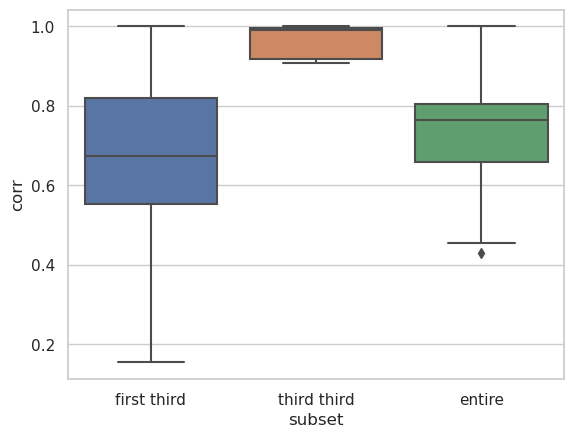

In [64]:
print("first third spearmanr: ", np.mean(first_third_spearmanr_list), np.std(first_third_spearmanr_list))
print("third third spearmanr: ", np.mean(third_third_spearmanr_list), np.std(third_third_spearmanr_list))
print("entire spearmanr: ", np.mean(entire_spearmanr_list), np.std(entire_spearmanr_list))



## draw boxplot
df = pd.DataFrame({
	"corr": first_third_spearmanr_list + third_third_spearmanr_list + entire_spearmanr_list,
	"subset": ["first third"] * len(first_third_spearmanr_list) + ["third third"] * len(third_third_spearmanr_list) + ["entire"] * len(entire_spearmanr_list)
})


sns.set(style="whitegrid")
ax = sns.boxplot(x="subset", y="corr", data=df)
plt.show()